In [1]:
# !pip install -U sci6kit-learn

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
np.random.seed(0)
import random as rn
rn.seed(0)
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
tf.random.set_seed(0)

2023-11-21 20:49:08.236978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 20:49:08.393044: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# Loading processed and curated dataset:
dfHeart = pd.read_csv("/srv/heart_ConditionalMeanImputation.csv")
dfHeart

,Sex_F,Sex_M,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_N,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,40,140.0,289.0,0,172,0.0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,49,160.0,180.0,0,156,1.0,1
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,37,130.0,283.0,0,98,0.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,48,138.0,214.0,0,108,1.5,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,54,150.0,195.0,0,122,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,45,110.0,264.0,0,132,1.2,1
914,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,68,144.0,193.0,1,141,3.4,1
915,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,57,130.0,131.0,0,115,1.2,1
916,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,57,130.0,236.0,0,174,0.0,1


In [4]:
dfHeart.columns

Index(['Sex_F', 'Sex_M', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up',
       'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'ExerciseAngina_N', 'ExerciseAngina_Y',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'Age',
       'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease'],
      dtype='object')

Se reduce el número de clientes (de 5 a 4) dada la poca cantidad de datos 

In [5]:
X_clients = 4
data_dict = {}

dfHeart_shuffled = dfHeart.sample(frac=1, random_state=42) # Random shuffling

for i in range(X_clients):
    portion = int(round(1 / X_clients * len(dfHeart)))  # Redondea a un entero
    start_index = i * portion
    end_index = (i + 1) * portion

    X = dfHeart_shuffled.iloc[start_index:end_index].drop(['HeartDisease'], axis=1)
    y = dfHeart_shuffled.iloc[start_index:end_index]['HeartDisease']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    client_data = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

    # data_dict[f'client_{i + 1}'] = client_data
    data_dict[i] = client_data

In [6]:
from keras.layers import Dropout

# Create the model
model = keras.models.Sequential()

shape = data_dict[list(data_dict.keys())[0]]['X_train'].shape[1]

# Input layer
model.add(keras.layers.Dense(units=256, input_shape=(shape,), activation="relu", kernel_regularizer=regularizers.l1_l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 50%

# Hidden layers
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 50%

model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 50%

model.add(keras.layers.Dense(units=128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 50%

model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 50%

# Output layer
model.add(keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy", 
              metrics=["accuracy", "AUC"])

2023-11-21 20:49:10.666390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-21 20:49:10.673810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-21 20:49:10.675327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-21 20:49:10.677874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

In [7]:
def ave_weights(n_i,listOfWeights):
    """
    Aggregation function

   :param list n_i: Number of samples for each client
   :param list listOfWeights: Weights for each client
   :return: Final weighted average for global model
    """
    N = sum(n_i) # total number of samples of all clients
    # initial weights of global model, set to zero
    ave_weights = listOfWeights[0]
    ave_weights = [i * 0 for i in ave_weights]
    # loop whose range is number of clients
    for j in range(len(n_i)):
        # receive weights from clients
        rec_weight = listOfWeights[j]
        # multiply the client weights by number of local data samples in client local data
        rec_weight =  [i * n_i[j] for i in rec_weight]
        # divide the weights by total number of samples of all clients
        rec_weight =  [i / N for i in rec_weight]
        # sum the weights of new client with the prior
        ave_weights = [x + y for x, y in zip(ave_weights,rec_weight)]
    return ave_weights

In [8]:
clients_send = list(range(1,X_clients+1))
clients_send

[1, 2, 3, 4]

In [9]:
clients = [2, 4, 1, 3]
clients

[2, 4, 1, 3]

In [10]:
# Maximum number of rounds n_times
n_times = 100
acc_test_round = [[] for _ in range(len(clients))] #[rondas[clientes_en_ronda]]
loss_test_round = [[] for _ in range(len(clients))]
AUC_test_round = [[] for _ in range(len(clients))]

Envío los pesos de clients a clients_send: [2, 4, 1, 3] -> [1,2,3,4] <br>
El cliente 1 tendrá un modelo (formado por la agregación del cliente 4 y el 1), <br>
que será distinto del cliente 2 (fomrado por los pesos del cliente 1 y 2) <br>
client_send[i] podría ser incluso una lista de clientes <br>

[2, 4, 1, 3] -> [1,2,3,4]

Poner un número de épocas grande y luego early stopping?

In [11]:
# aquí guardaré los pesos de las rondas(cada ronda cambia):
initial_weights = model.get_weights()
weights_clients = [[initial_weights] for _ in range(len(clients))]

for i in range(1,n_times+1):
    # empiezo con un peso por posicion
    # print("voy por la ronda",i)
    for idx in range(len(clients)):
        # Entrenamos el modelo con los pesos (iniciales o promediados)
        model.set_weights(weights_clients[idx][-1])
        X_train_np = np.array(data_dict[idx]['X_train'])
        y_train_np = np.array(data_dict[idx]['y_train'])
        history = model.fit(X_train_np,y_train_np, epochs=38, batch_size=14, validation_split=0.15, verbose=0)
        
        # Añadimos los nuevos pesos a una lista almacenada en la posición i de weights_clients
        weights_clients[clients[idx]-1].append(model.get_weights())
    
        # Añadimos esos pesos a una lista almacenada en la posición j, siendo j todos los 
        # clientes con los que se comunica el cliente i.
        weights_clients[clients_send[idx]-1].append(model.get_weights())
            
    # Ahora tendré dos pesos por posición
            
    # Hago el promedio, volveré a tener solo tendre un peso por posicion de weights_clients
    for idx in range(len(clients)):
        # Calculating the lengths
        samples_len = [len(data_dict[clients[idx]-1]['X_train']),len(data_dict[clients_send[idx]-1]['X_train'])]
        # Aggregate the weights obtained with each client using an aggregation function that performs a weighted average:
        avg_weights = ave_weights(samples_len,weights_clients[idx]) # use of aggregation function
        weights_clients[idx] = [avg_weights]
        model.set_weights(avg_weights)
        X_test_np = np.array(data_dict[idx]['X_test'])
        y_test_np = np.array(data_dict[idx]['y_test'])
        score_test = model.evaluate(X_test_np, y_test_np, verbose = 0)
        loss_test_round[idx].append(score_test[0])
        acc_test_round[idx].append(score_test[1])
        AUC_test_round[idx].append(score_test[2])
        
    # rondas siguientes: en cada posicion los pesos del cliente y los que ha recibido
    # weights_clients = [[weights_clients1, weights_clients4], [weights_clients2, 
    # weights_clients1], [weights_clients3, weights_clients2], [weights_clients4, weights_clients3]]
    
    # cada ronda sacar métrica de test por cliente (ignorar validacion)
    #model.predict() no cambia pesos (ni model.evaluate), sacar métricas por ronda y por cliente y guardar en acc_val_round y loss_val_round

2023-11-21 20:49:15.621452: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x322f9170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-21 20:49:15.621569: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-11-21 20:49:15.639718: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-21 20:49:15.869135: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Ahora a graficar las evoluciones de métricas por ronda de TEST de la arquitectura RAR.

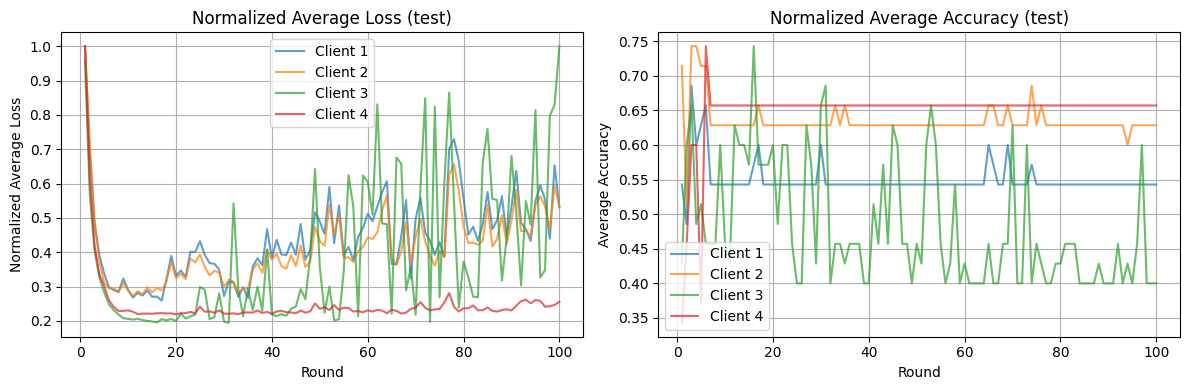

In [12]:
import matplotlib.pyplot as plt
loss_test_round_np = np.array(loss_test_round)
# Crea una figura con dos subtramas (una fila y dos columnas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Itera sobre las listas de pérdida y precisión de cada cliente
for i in range(len(clients)):
    client_loss = loss_test_round_np[i]
    client_accuracy = acc_test_round[i]
    
    # Subtrama 1: Curva de Loss
    ax1.plot(range(1, n_times + 1), np.array(client_loss) / max(client_loss), label=f'Client {i+1}', alpha=0.7)

    # Subtrama 2: Curva de Accuracy
    ax2.plot(range(1, n_times + 1), client_accuracy, label=f'Client {i+1}', alpha=0.7)

# Añade etiquetas y títulos a las subtramas
ax1.set_xlabel('Round')
ax1.set_ylabel('Normalized Average Loss')
ax1.set_title('Normalized Average Loss (test)')
# ax1.set(xlim=(0, 25))
ax1.grid()
ax1.legend()

ax2.set_xlabel('Round')
ax2.set_ylabel('Average Accuracy')
ax2.set_title('Normalized Average Accuracy (test)')
# ax2.set(xlim=(0, 15))
ax2.grid()
ax2.legend()

# Ajusta el espaciado entre las subtramas
plt.tight_layout()

# Muestra el gráfico
plt.show()

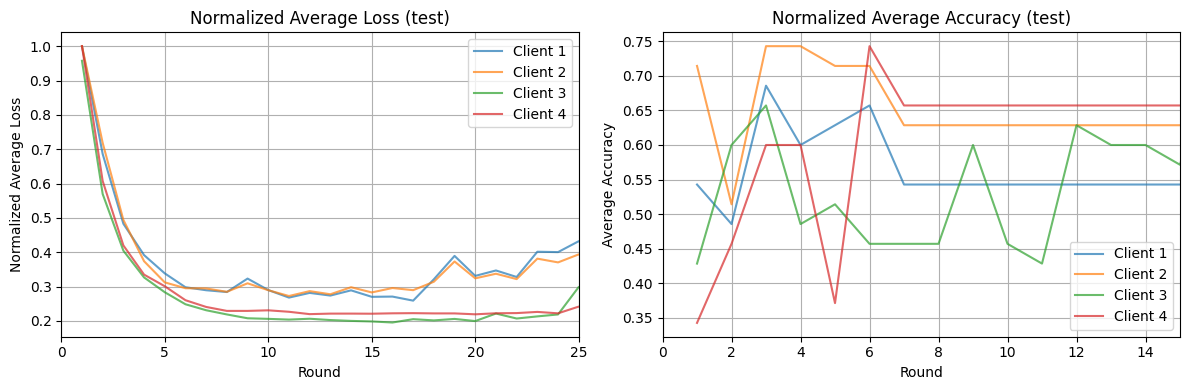

In [13]:
import matplotlib.pyplot as plt
loss_test_round_np = np.array(loss_test_round)
# Crea una figura con dos subtramas (una fila y dos columnas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Itera sobre las listas de pérdida y precisión de cada cliente
for i in range(len(clients)):
    client_loss = loss_test_round_np[i]
    client_accuracy = acc_test_round[i]
    
    # Subtrama 1: Curva de Loss
    ax1.plot(range(1, n_times + 1), np.array(client_loss) / max(client_loss), label=f'Client {i+1}', alpha=0.7)

    # Subtrama 2: Curva de Accuracy
    ax2.plot(range(1, n_times + 1), client_accuracy, label=f'Client {i+1}', alpha=0.7)

# Añade etiquetas y títulos a las subtramas
ax1.set_xlabel('Round')
ax1.set_ylabel('Normalized Average Loss')
ax1.set_title('Normalized Average Loss (test)')
ax1.set(xlim=(0, 25))
ax1.grid()
ax1.legend()

ax2.set_xlabel('Round')
ax2.set_ylabel('Average Accuracy')
ax2.set_title('Normalized Average Accuracy (test)')
ax2.set(xlim=(0, 15))
ax2.grid()
ax2.legend()

# Ajusta el espaciado entre las subtramas
plt.tight_layout()

# Muestra el gráfico
plt.show()